### Explore City of Scottsdale Arrests dataset

In [46]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


In [267]:
files = glob.glob('data/*.csv')

arrests = pd.concat([pd.read_csv(f) for f in files], sort=True)

In [269]:
# convert columns to lower case, replace spaces with underscore
def setcols(df, fn=lambda x: x.columns.map('_'.join), cols=None):
    if cols:
        df.columns = cols
    else:
        df.columns = fn(df)
    return df

arrests = arrests.pipe(
        setcols,
        fn=lambda x: x.columns.str.lower()
        .str.strip()
        .str.replace(" ", "_")
        .str.replace("#", "number"))

In [288]:
# convert arrest_date to datetime format
arrests.arrest_date = pd.to_datetime(arrests.arrest_date)

# combine both month and year into same column
arrests['year_month'] = arrests['arrest_date'].apply(lambda x: str(x.year) + '.' + str(x.month).zfill(2))
arrests.year_month = arrests.year_month.astype(str)

In [260]:
# glance at the data
arrests.shape

(16693, 17)

In [270]:
# strip out whitespace
arrests = arrests.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [285]:
# remove index, this was creating a conflict
arrests = arrests.reset_index(drop=True)

In [272]:
arrests.head()

,age,arizona_statute_code,arrest_number,arrest_date,arrest_location,arrest_time,arrest_type,arrestee,beat,charge_description,city_of_arrestee,dr_number,district,officer_serialnumber,race,sex,zone
0,NaN,WARRANT,18-16071,07/21/2018,N Saddlebag Tr,00:00,Booked,"Diaz Castillo, Jose L",06,Warrant - Misd - Other Jurisdiction,"Phoenix, AZ 85008",18-16071,D2,1472,W,M,904
1,NaN,13-2904A1,18-16076,07/21/2018,E Continental DR,00:00,Booked,"Blocker, Robert",01,Disorderly Conduct-Disruptive Behavior,"Gurnee, IL 60031",18-16076,D1,1395,B,M,201
2,NaN,13-3415A,18-16083,07/22/2018,E Indian Pz,00:00,Booked,"King, Harold Jarrett",06,Drug Paraphernalia-Possess/Use,"Calgary, AB T2K2P",18-16083,D2,1496,W,M,904
3,NaN,13-1104A1,18-15909,07/19/2018,E Redfield Rd / N Scottsdale Rd,00:00,Cite In Lieu of Detention,"Silvestro, Vincenzo",15,Murder 2nd Degree-Intentional,"Phoenix, AZ 85254",18-15909,D4,1262,W,M,3401
4,NaN,13-1303A,18-16156,07/23/2018,E McCormick Py / N Scottsdale Rd,00:00,Cite In Lieu of Detention,"Fisher, Alize Nicole",10,Unlawful Imprisonment,"Lansing, MI 48910",18-16156,D3,1459,B,F,2502


In [286]:
# check for duplicates
# I was expecting more with the overlap in the downloaded data
arrests[arrests.duplicated()]

,age,arizona_statute_code,arrest_number,arrest_date,arrest_location,arrest_time,arrest_type,arrestee,beat,charge_description,city_of_arrestee,dr_number,district,officer_serialnumber,race,sex,zone
10553,24,28-701.02A3,NaN,02/28/2019,L101 / E Shea Bl,00:00,Cite In Lieu of Detention,"Ralston, Joshua D",12,Exceed 85 mph,"Queen Creek, AZ 85142",19-04635,D3,1492,B,M,3006
11724,26,28-3473A,NaN,12/06/2018,N Scottsdale Rd,00:00,Cite In Lieu of Detention,"Smith, Coleman Patrick",11,Suspended/Revoked D.L.,"Scottsdale, AZ 85253",18-26309,D3,1262,W,M,2904


In [61]:
# groupby year + month to find count of arrests over time
# are more arrests happening at specific times of the year?
arrests.groupby(arrests.year_month).size().head()

year_month
2017.09     89
2017.1     414
2017.11    345
2017.12    384
2018.01    391
dtype: int64

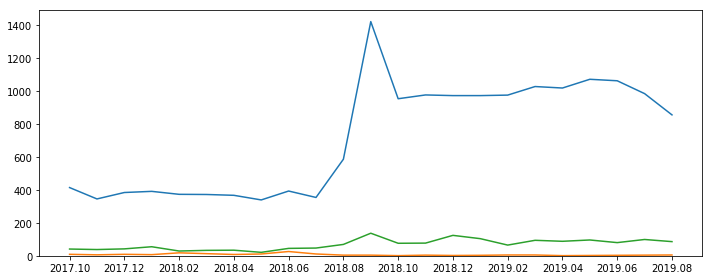

In [294]:
# graph count of arrests over time
# exclude sept. 2017 since I have such a small portion of the month
fig = plt.figure(figsize=(10, 4))
ax = plt.axes() 

plt.plot(arrests.groupby(arrests.year_month).size().index[1:],
         arrests.groupby(arrests.year_month).size().values[1:])

plt.plot(arrests.loc[arrests.charge_description == 'Liquor-Under 21 Any Liquor In Body'].groupby(arrests.year_month).size().index[1:],
         arrests.loc[arrests.charge_description == 'Liquor-Under 21 Any Liquor In Body'].groupby(arrests.year_month).size().values[1:])

plt.plot(arrests.loc[arrests.charge_description == 'DUI-Impaired to Slightest Degree'].groupby(arrests.year_month).size().index[1:],
         arrests.loc[arrests.charge_description == 'DUI-Impaired to Slightest Degree'].groupby(arrests.year_month).size().values[1:])



plt.ylim(0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.tight_layout()

In [14]:
arrests.charge_description.value_counts().head(10)

Suspended/Revoked D.L.                                 577
DUI-Impaired to Slightest Degree                       474
Marijuana-Possess/Use                                  194
Drug Paraphernalia-Possess/Use                         191
Liquor-Under 21 Any Liquor In Body                     126
Violation of Promise to Appear                         121
Alcohol/Toxic Vapors/ Drug Incapacitation In Public    113
Warrant - Fel - Other Jurisdiction                     109
Exceed Limit By More Than 20mph                        104
Rule 26.12 Fail to Comply- Pre-Adjudication             99
Name: charge_description, dtype: int64

In [296]:
# what does 'arrest number' mean?
# 'arrest number' seems to be the same as 'dr number'
arrests.arrest_number.value_counts().head()

17-26284    5
17-23470    4
17-22834    3
18-04470    3
17-26294    3
Name: arrest_number, dtype: int64

In [297]:
# it's unclear to me why these all have the same arrest_number
arrests.groupby('arrest_number').get_group("17-26284")

,age,arizona_statute_code,arrest_number,arrest_date,arrest_location,arrest_time,arrest_type,arrestee,beat,charge_description,city_of_arrestee,dr_number,district,officer_serialnumber,race,sex,zone,year_month
3017,NaN,13-3415A,17-26284,2018-02-25,N Country Club DR,23:04,Booked,"Maiorana, Andrew Richard",99,Drug Paraphernalia-Possess/Use,"Mesa, AZ 85201",17-26284,,1330,W,M,99,2018.02
3018,NaN,13-3405A1,17-26284,2018-01-31,N Country Club DR / E McKellips Rd,10:11,Booked,"Lentino, Caressea Beth",99,Marijuana-Possess/Use,"Mesa, AZ 85201",17-26284,,721,W,F,99,2018.01
3019,NaN,28-1381A1,17-26284,2017-11-27,N Scottsdale Rd / E Tierra Buena Ln,00:00,Court Ordered Fingerprints,"Lentino, Caressea Beth",15,DUI-Impaired to Slightest Degree,"Mesa, AZ 85201",17-26284,D4,788,W,F,3601,2017.11
3020,NaN,13-1402A,17-26284,2018-04-02,E Talking Stick Wy,04:11,Booked,"Lentino, Caressea Beth",99,Indecent Exposure,"Mesa, AZ 85201",17-26284,,1457,W,F,99,2018.04
3021,NaN,19-13,17-26284,2017-11-27,N Scottsdale Rd / E Tierra Buena Ln,00:00,Cite In Lieu of Detention,"Woodward, Jacob Daniel",15,F/Obey Police Officer,"Mesa, AZ 85201",17-26284,D4,788,W,M,3601,2017.11


In [299]:
# what does the 'dr_number' mean?
arrests.dr_number.value_counts().head()

19-11227    7
19-08958    7
18-17686    6
18-23203    6
18-27961    6
Name: dr_number, dtype: int64

In [249]:
arrests.groupby('dr_number').get_group("19-11227")

,index,age,arizona_statute_code,arrest_number,arrest_date,arrest_location,arrest_time,arrest_type,arrestee,beat,charge_description,city_of_arrestee,dr_number,district,officer_serialnumber,race,sex,zone
4464,9,20,13-1105A1,NaN,07/19/2019,N 75th St,09:30,Booked,"Vitela, Joseph Isaac",06,Murder 1st Degree-Premeditated,"Phoenix, AZ 85037",19-11227,D2,541,W,M,9901
4855,400,27,13-1105A1,NaN,08/01/2019,E Virginia Av,09:19,Booked,"Tatum, Tyshaun Larae",99,Murder 1st Degree-Premeditated,"Phoenix, AZ 85040",19-11227,,541,B,M,99
5114,659,25,13-2512A,NaN,08/09/2019,W Mariposa St,18:32,Booked,"Lynch, Anthony Keshaun",,Hindering Prosecution 1st Deg,"Phoenix, AZ 85037",19-11227,,541,B,M,0
15446,10991,21,13-1105A1,NaN,06/13/2019,S Terrace Road,00:00,Booked,"Bird, Joshua Levi",,Murder 1st Degree-Premeditated,"Peoria, AZ 85345",19-11227,99,1131,W,M,0
15447,10992,20,13-1105A1,NaN,06/13/2019,W Purdue Av,00:00,Booked,"Valdez, Sergio",,Murder 1st Degree-Premeditated,"Peoria, AZ 85345",19-11227,,1446,W,M,0
15678,11223,20,13-1105A1,NaN,06/19/2019,E Apache Bl,16:49,Booked,"Bjornholt, Matthew Eric",,Murder 1st Degree-Premeditated,"Tempe, AZ 85281",19-11227,,541,W,M,0
16641,12186,24,13-3408A1,NaN,07/18/2019,W McDowell Rd,00:00,Booked,"Garcia, Isaac Jonathan",,Narcotic Drug (Synthetic/Rx)-Possess/Use,"Phoenix, AZ 85035",19-11227,,541,W,M,0


In [301]:
np.sum(arrests.dr_number.isna())

0

In [302]:
np.sum(arrests.arrest_number.isna())

12238

In [279]:
# groupby primary fields to determine if people are recorded once when arrested.
arrests.groupby([arrests.age, arrests.arrestee, arrests.arrest_date]).size().sort_values(ascending=False).head(15)

age  arrestee                   arrest_date
53   Motley, Stacy Lamar        06/25/2019     14
19   Chief, Stephanie Lee Ann   09/13/2018      9
24   Pechac, Rena               09/13/2018      9
25   Chief, Anthony Matthew     09/13/2018      9
22   Garcia, Caprice Valentina  06/27/2019      9
30   Gonzalez, Michael Anthony  05/26/2019      8
                                08/30/2018      7
39   Farris, William            02/23/2019      7
48   Daehling, Blair John       09/26/2018      7
41   Mudgette, Ian Anthony      08/25/2018      7
37   Tracey, Joshua Alan        04/30/2019      6
47   Walser, Matthew David      12/24/2018      6
28   Bach, Jonathan Sebastian   06/14/2019      6
30   Gonzalez, Michael Anthony  10/20/2018      6
31   Vosberg, Nathaniel Tory    05/23/2019      5
dtype: int64

In [281]:
# some people who have been arrested have multiple records and dr_numbers
arrests.groupby(arrests.arrestee).get_group('Motley, Stacy Lamar')

,age,arizona_statute_code,arrest_number,arrest_date,arrest_location,arrest_time,arrest_type,arrestee,beat,charge_description,city_of_arrestee,dr_number,district,officer_serialnumber,race,sex,zone
15052,53,13-1805A1,NaN,06/01/2019,N Frank Lloyd Wright Bl,00:00,Booked,"Motley, Stacy Lamar",17,Shoplifting-Removal of Goods,"Phoenix, AZ 85007",19-11793,D4,1454,B,M,3404
15873,53,13-1819A1,NaN,06/25/2019,S 7th Av,00:00,Booked,"Motley, Stacy Lamar",,Theft - Organized Retail,"Phoenix, AZ 85007",19-12595,,1454,B,M,0
15874,53,13-1819A2,NaN,06/25/2019,S 7th Av,00:00,Booked,"Motley, Stacy Lamar",,Theft - Organized Retail-Artifice,"Phoenix, AZ 85007",19-12597,,1454,B,M,0
15875,48,13-1819A2,NaN,06/25/2019,S 7th Av,00:00,Booked,"Motley, Stacy Lamar",,Theft - Organized Retail-Artifice,"Phoenix, AZ 85007",19-12598,,1454,B,M,0
15876,53,13-1819A2,NaN,06/25/2019,S 7th Av,00:00,Booked,"Motley, Stacy Lamar",,Theft - Organized Retail-Artifice,"Phoenix, AZ 85007",19-12599,,1454,B,M,0
15877,53,13-1819A2,NaN,06/25/2019,S 7th Av,00:00,Booked,"Motley, Stacy Lamar",,Theft - Organized Retail-Artifice,"Phoenix, AZ 85007",19-12600,,1454,B,M,0
15878,53,13-1819A2,NaN,06/25/2019,S 7th Av,00:00,Booked,"Motley, Stacy Lamar",,Theft - Organized Retail-Artifice,"Phoenix, AZ 85007",19-12601,,1454,B,M,0
15879,53,13-1819A1,NaN,06/25/2019,S 7th Av,00:00,Booked,"Motley, Stacy Lamar",,Theft - Organized Retail,"Phoenix, AZ 85007",19-12602,,1454,B,M,0
15880,53,13-1819A1,NaN,06/25/2019,S 7th Av,00:00,Booked,"Motley, Stacy Lamar",,Theft - Organized Retail,"Phoenix, AZ 85007",19-12603,,1454,B,M,0
15881,53,13-1819A2,NaN,06/25/2019,S 7th Av,00:00,Booked,"Motley, Stacy Lamar",,Theft - Organized Retail-Artifice,"Phoenix, AZ 85007",19-13425,,1454,B,M,0


In [178]:
from scipy.stats import ttest_ind

ttest_ind(arrests1.Age, arrests1['Arrest Time'])

C:\Users\mrkjh\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [15]:
arrests.race.value_counts()

W     3638
B      604
I      167
A       42
U        2
P        2
Name: race, dtype: int64

In [18]:
arrests.arrest_location.value_counts().head(10)

N Scottsdale Rd    293
E Camelback Rd     215
E McDowell Rd      150
E Thomas Rd        134
N Saddlebag Tr     124
N 75th St          116
N Hayden Rd        115
E Shea Bl          115
E Indian Pz        101
S 4th Av            94
Name: arrest_location, dtype: int64

In [20]:
arrests.arrest_type.value_counts()

Booked                              3040
Cite In Lieu of Detention           1199
Court Ordered Fingerprints           131
Booked - Task Force                   80
Mandatory Fingerprint Compliance       3
Juv Referral-Field Release             1
Runaway                                1
Name: arrest_type, dtype: int64